In [61]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras
import time
import imutils
import hashlib
import pickle

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from typing import List
from pathlib import Path
from imutils.video import VideoStream
from PIL import Image

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Data Preprocessing

The training and testing images are provided to us as raw values in a csv file column called "pixels" and not as raw image files.

We need to preprocess this data such that the string raw values become a numpy array representing a grayscale image.

Each row of the data file is one image, with corresponding label "emotion", and a "usage" of what the image is to be used for.

In the following section, we will work with the column "pixels" and turn it into numpy arrays that can be used for training the model.

#### STEP 1 ####
Load the raw dataset and take a look to understand what we are working with

In [10]:
filename = 'dataset/emotions_train_dataset.csv'
df = pd.read_csv(filename, na_filter=False)

In [11]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


*emotion* - contains the values 0 - 6, and maps to the labels in *label_map* (in order)

*pixels* - a STRING containing the raw grayscale value to s SQUARE image


### STEP 2

How many values are in each "pixels" row? Write some code to figure this out!

Given how many values are in each "pixels" data, what is the size of the square array that we need to rearrange this into in order to make a square image?

### STEP 3

Write a function to convert each "pixels" string into a numpy array of the correct shape

To make this easier, first create a test variable that is such a string of raw pixel values, then write a function to convert it.

In [13]:
test_pixels = df.iloc[0, 1]

In [23]:
def pixels_to_image(pixels) -> np.ndarray:
    pixels_lists = [int(n) for n in pixels.split()]
    X = np.array(pixels_lists) / 255
    X = X.reshape(48, 48)
    return X

In [18]:
test_image = pixels_to_image(test_pixels)

What is the shape the resulting array?

Is it two dimensional or three dimensional?

We actually want a four dimensional array (1, height, width, channels) where "channels" is the number of color channels.

For a grayscale image, the chanell will simply be 1. For RGB image, this will be 3.

We would like to have a four dimensional array because later we will be concatenating the arrays together from all images into one single numpy array. The concatenation will occur on the first dimension.

Can you update the pixels_to_image function to reshape the image array into a (1, height, width, 1) array for grayscale?

In [37]:
def pixels_to_image(pixels) -> np.ndarray:
    pixels_lists = [int(n) for n in pixels.split()]
    X = np.array(pixels_lists) / 255
    X = X.reshape(1, 48, 48, 1)
    return X

In [38]:
test_image = pixels_to_image(test_pixels)
test_image.shape

(1, 48, 48, 1)

### STEP 4

Apply your function to the "pixels" data series to obtain a list of numpy image arrays "X"

In [39]:
X = df.pixels.apply(pixels_to_image)

What is the data type of X?

In [40]:
type(X)

pandas.core.series.Series

What is the data type of the first element of X?

In [41]:
type(X[0])

numpy.ndarray

Finally convert this list of numpy arrays into a single numpy array, by using "np.concatenate"

In [43]:
X = np.concatenate(X)

Verify that the shape of *X* is (32298, width, height, 1)

The first dimension is each of the images (32298 of them)

The second and third dimensions are the width and height

The last dimension if the number of color channels = 1

In [46]:
X.shape

(32298, 48, 48, 1)

### STEP 5

Just having the images are not enough for training. We also need the emotion labels that correspond to each image.

Create a variabe *Y* which is an INTEGER version of the df dataframe column "emotion"

In [55]:
Y = df.emotion.astype(int)

Integer labels are useful for model training (as each number represents an output class), however, it is not as intuitive to quickly view the images with the corresponding expressions.

Create a variable called *labels* from the variable *Y*, which maps the integer class to a emotion name (given in *label_map*)

In [56]:
labels = [label_map[e] for e in Y]

### STEP 6

Processing the images above took a bit of time. It might be somewhat annoying to repeat this every time you rerun this notebook.

To save time, we will save our final numpy array in a file, and just load it in the next time we run the notebook, skipping everything above (except the imports)!

In the following code, if 'dataset/numpy_images.npy' exists, then we load it in as variable *X*.

If it does not exists, we need to write *X* to the file (make sure you have ran the code above to get numpy array *X*)

In [65]:
npy_data = 'dataset/numpy_images.npy'
label_data = 'dataset/labels.pkl'
if Path(npy_data).is_file() and Path(label_data).is_file():
    print('Loading from previously processed training data X and labels Y')
    with open(npy_data, 'rb') as f:
        X = np.load(f)
    with open(label_data, 'rb') as f:
        Y = pickle.load(f)
else:
    print('No training numpy array saved previously. Saving variable X to file.')
    with open(npy_data, 'wb') as f:
        np.save(f, X)
    with open(label_data, 'wb') as f:
        pickle.dump(Y, f)

assert X.shape == (32298, 48, 48, 1)
print(f'Validated that X.shape is (32298, 48, 48, 1)')

assert len(Y) == X.shape[0]
print(f'Validated that len(Y) is {len(Y)}')

Loading from previously processed training data X and labels Y
Validated that X.shape is (32298, 48, 48, 1)
Validated that len(Y) is 32298


### STEP 5

So far we've only processed the raw data, but have not even looked at how the images appear yet.

Let's write some visualization code to see some random images and their emotion labels, and plot them on a grid of 4 x 5 table.

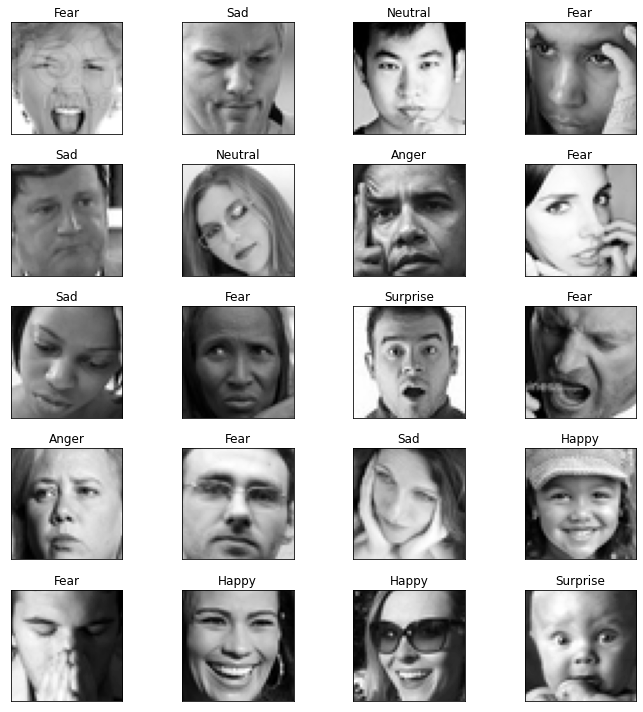

In [59]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    # Randomly choose an image, img_id should be a random integer going from 0, up to a total number of images in X
    img_id = np.random.choice(X.shape[0])
    
    # Select the numpy array corresponding to the index that is randomly chosen
    img = X[img_id, :, :, 0]
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Add the emotion label for the selected image as the title
    plt.title(labels[img_id])

fig.tight_layout()
plt.show()

### STEP 7 (optional)

Write your own data visualization or analysis code to further explore the data.

You can choose to answer some of these questions

1. How is the data distributed across each of the emotions? Which emotion has the most images? Which emotion has the least?

2. Are there particular emotion images that may be incorrect or ambiguous? Correcting them may give you better results when applying the model to the real world.

3. What is the average pixel "brightness" in these images? Are there outliers that need to be adjusted?

### Training and validation split

Before we can train and evaluate our model, we need to first split our X, and Y variables into training and validation dataset.

Write some code below to do so.

You should end up with 4 variables, where the validation dataset contains 10% of the total data.

*X_train*

*X_val*

*y_train*

*y_val*


In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=0)


Check the shape of each of the above variables to make sure they are reasonable

### STEP 8

Because the training images for this dataset are small (48x48) and we do not have a lot of them, it is ok for now to load all the images into the computer memory while training (next up).

However, if we start working with a large dataset of bigger images (for example 240x240), you may quickly run out of memory if you try to read them all into memory.

For this reason, it is better to save the images as files, and read them into memory as they are needed during training (using what's called a `generator` function, we highly encourage you to look up what this is).

In this step, you'll write the files to disk as grayscale images, with two different resolutsion (48x48) and (224x224).


In [ ]:
def generate_id(digest_size=4):
    hash = hashlib.blake2b(digest_size=digest_size)
    hash.update(str(time.time()).encode('utf-8'))
    return hash.hexdigest()

In [ ]:
def write_array_to_image_files(X, y, resolution, dataset_name)
    arrays = []
    for arr in X[:,:,:,0]:
        arrays.append(np.array(Image.fromarray(arr).resize(size=(resolution, resolution))))
    resized_array = np.array(arrays)
    resized_array = np.expand_dims(resized_array, axis=-1)
    resized_array = np.concatenate([resized_array, resized_array, resized_array], axis=-1)
    
    # First create the directories that corresponds to the target class name
    for k in set(y):
        dir_path = Path(f'dataset/{dataset_name}/{str(k)}')
        dir_path.mkdir(parents=True, exist_ok=True)
        
    # Write each image into the target class folder
    # Remember to multiple by 255 as our array data is normalized to 1
    for arr, i in zip(resized_array, y):
        im = Image.fromarray(np.uint8(arr*255))
        im.save(f'dataset/{dataset_name}/{str(i)}/{generate_id()}.jpg')

In [1]:
for X, y, dataset_name in zip([X_train, X_val], [y_train, y_val], ['train', 'val']):
    write_array_to_image_files(X, y, 224, dataset_name)

### We are done with data processing!! You can move on to the "ExpressionNet Training and Evaluation - ConvNet" notebook for model training!